# Multi-Class Feed Forward Network
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hemendrarajawat/World-With-Deep-Learning/blob/master/notebooks/Multi-Class%20Feed%20Forward%20Network.ipynb)

Till now we have seen only binary classification, let's see how well Feed Forward Network works for Multi-Class Classification.

## Import Libaries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(0)
my_cmap = LinearSegmentedColormap.from_list('', ['red', 'yellow', 'green'])

## Multi-Class Feed Forward Network Class

In [0]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    np.random.seed(0)
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      np.random.seed(0)
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      print('Minimum Loss:', loss[min(loss, key=loss.get)])
      print('Loss after training:', loss[len(loss.keys())-1])
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

## Dataset 1 -> 4 Blobs

### Generate Data

In [0]:
data, labels = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=0)

### Visualize Data

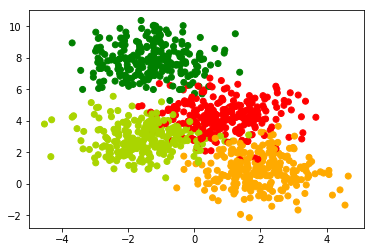

In [4]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

### Train-Test Split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify=labels, random_state=0, test_size=0.4)

### Convert Data into One Hot Encoded Form

In [6]:
OHEncoder = OneHotEncoder()
Y_OH_train = OHEncoder.fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_OH_test = OHEncoder.transform(Y_test.reshape(-1, 1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
print(Y_OH_train[1, :], Y_train[1])
print(Y_OH_test[1, :], Y_test[1])

[1. 0. 0. 0.] 0
[0. 0. 0. 1.] 3


### Train the Model


Minimum Loss: 0.17375588327087738
Loss after training: 0.17375588327087738


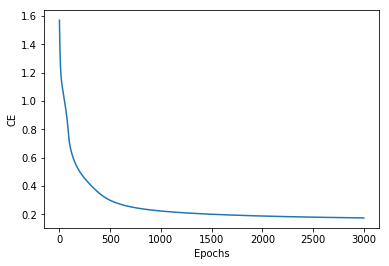

In [8]:
blobs_model = FFSN_MultiClass(X_train.shape[1], Y_OH_train.shape[1], hidden_sizes=[4])
blobs_model.fit(X_train, Y_OH_train, epochs=3000, learning_rate=0.001, display_loss=True)

### Validate the Model

In [9]:
Y_pred_train = blobs_model.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = blobs_model.predict(X_test)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.93
Validation accuracy 0.93


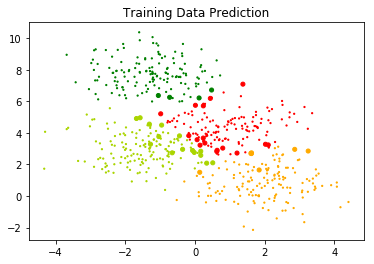

In [10]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.title('Training Data Prediction')
plt.show()

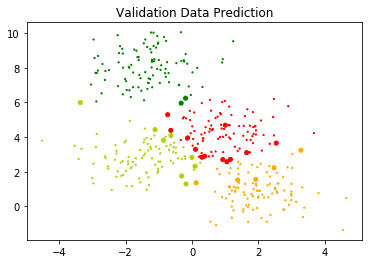

In [11]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_pred_val, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_val-Y_test))+.1))
plt.title('Validation Data Prediction')
plt.show()

## Dataset 2 -> 6 Blobs

### Generate Dataset

In [0]:
data, labels = make_blobs(n_samples=2000, n_features=2, centers=6, random_state=0, cluster_std=0.75)

### Visualize the data

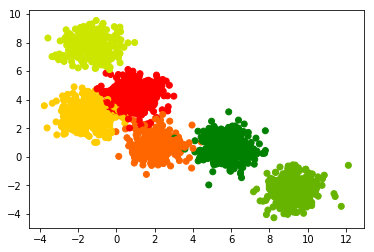

In [13]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

### Train-Test Split

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify=labels, random_state=0, test_size=0.4)

### One Hot Encoding

In [15]:
OHEncoder = OneHotEncoder()
Y_OH_train = OHEncoder.fit_transform(Y_train.reshape(-1, 1)).toarray()
Y_OH_test = OHEncoder.transform(Y_test.reshape(-1, 1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Train the Model


Minimum Loss: 0.07268408967890398
Loss after training: 0.07268408967890398


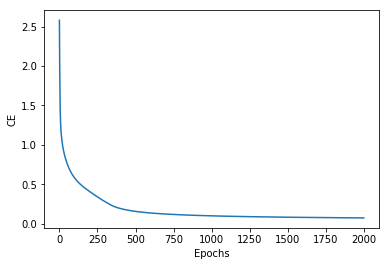

In [16]:
blobs_model = FFSN_MultiClass(X_train.shape[1], Y_OH_train.shape[1], hidden_sizes=[5])
blobs_model.fit(X_train, Y_OH_train, epochs=2000, learning_rate=0.001, display_loss=True)

### Validate the Model

In [17]:
Y_pred_train = blobs_model.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = blobs_model.predict(X_test)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val, Y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.98
Validation accuracy 0.98


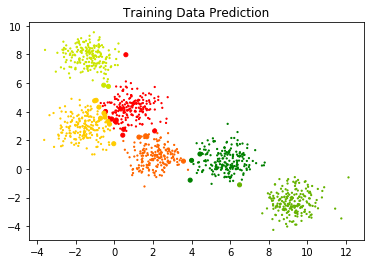

In [18]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.title('Training Data Prediction')
plt.show()

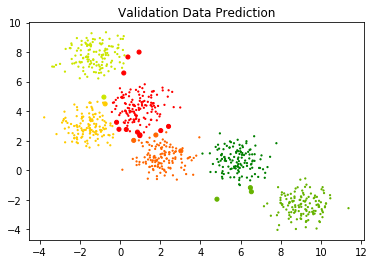

In [19]:
plt.scatter(X_test[:,0], X_test[:,1], c=Y_pred_val, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_val-Y_test))+.1))
plt.title('Validation Data Prediction')
plt.show()

## Conclusion

Yes, with Deep Neural Networks we can predict the output accurately.